In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

In [3]:
from plotly.offline import init_notebook_mode, iplot, plot
init_notebook_mode(connected = True)
import plotly.express as px
import plotly.graph_objects as go

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [5]:
import tensorflow as tf

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.metrics import BinaryAccuracy

## 1. Load data

In [7]:
dataset = pd.read_csv("data\datatest.txt")
dataset.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
140,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
141,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
142,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
143,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
144,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1


In [8]:
dataset2 = pd.read_csv("data\datatest2.txt")
dataset2.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-11 14:48:00,21.7600,31.133333,437.333333,1029.666667,0.005021,1
2,2015-02-11 14:49:00,21.7900,31.000000,437.333333,1000.000000,0.005009,1
3,2015-02-11 14:50:00,21.7675,31.122500,434.000000,1003.750000,0.005022,1
4,2015-02-11 14:51:00,21.7675,31.122500,439.000000,1009.500000,0.005022,1
5,2015-02-11 14:51:59,21.7900,31.133333,437.333333,1005.666667,0.005030,1


In [9]:
datatraining = pd.read_csv("data\datatraining.txt")
datatraining.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


## 2. EDA

In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2665 entries, 140 to 2804
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           2665 non-null   object 
 1   Temperature    2665 non-null   float64
 2   Humidity       2665 non-null   float64
 3   Light          2665 non-null   float64
 4   CO2            2665 non-null   float64
 5   HumidityRatio  2665 non-null   float64
 6   Occupancy      2665 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 166.6+ KB


In [11]:
dataset2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9752 entries, 1 to 9752
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           9752 non-null   object 
 1   Temperature    9752 non-null   float64
 2   Humidity       9752 non-null   float64
 3   Light          9752 non-null   float64
 4   CO2            9752 non-null   float64
 5   HumidityRatio  9752 non-null   float64
 6   Occupancy      9752 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 609.5+ KB


In [12]:
datatraining.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8143 entries, 1 to 8143
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           8143 non-null   object 
 1   Temperature    8143 non-null   float64
 2   Humidity       8143 non-null   float64
 3   Light          8143 non-null   float64
 4   CO2            8143 non-null   float64
 5   HumidityRatio  8143 non-null   float64
 6   Occupancy      8143 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 508.9+ KB


All text files has seven columns as date, temperature, humidity, light, CO2, humidity ratio and occupancy.

    Temperature in Celsius.
    Relative humidity as a percentage.
    Light measured in lux.
    Carbon dioxide measured in parts per million.
    Humidity ratio, derived from temperature and relative humidity measured in kilograms of water vapor per kilogram of air.
    Occupancy as either 1 for occupied or 0 for not occupied.

For training and testing the models, I will use I will use datatraining(8143 instances) as training, datatest(2665 instances) as validation and datatest2(9752 instances) as test data.

In [13]:
def convert_to_datetime(dataset):
    dataset["date"] = pd.to_datetime(dataset["date"])
    dataset.reset_index(drop = True, inplace = True)
    return dataset

In [14]:
dataset = convert_to_datetime(dataset)
dataset2 = convert_to_datetime(dataset2)
datatraining = convert_to_datetime(datatraining)

In [15]:
datatraining.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature,8143.0,20.619084,1.016916,19.000000,19.700000,20.390000,21.390000,23.180000
Humidity,8143.0,25.731507,5.531211,16.745000,20.200000,26.222500,30.533333,39.117500
Light,8143.0,119.519375,194.755805,0.000000,0.000000,0.000000,256.375000,1546.333333
CO2,8143.0,606.546243,314.320877,412.750000,439.000000,453.500000,638.833333,2028.500000
HumidityRatio,8143.0,0.003863,0.000852,0.002674,0.003078,0.003801,0.004352,0.006476
Occupancy,8143.0,0.212330,0.408982,0.000000,0.000000,0.000000,0.000000,1.000000


In [17]:
dataset = dataset.set_index("date")
dataset2 = dataset2.set_index("date")
datatraining = datatraining.set_index("date")

In [21]:
dataset.index.min(), dataset.index.max()

(Timestamp('2015-02-02 14:19:00'), Timestamp('2015-02-04 10:43:00'))

In [23]:
dataset2.index.min(), dataset2.index.max()

(Timestamp('2015-02-11 14:48:00'), Timestamp('2015-02-18 09:19:00'))

In [24]:
datatraining.index.min(), datatraining.index.max()

(Timestamp('2015-02-04 17:51:00'), Timestamp('2015-02-10 09:33:00'))

In [28]:
cols_plot = ["Temperature", "Humidity", "Light", "CO2", "HumidityRatio"]

In [29]:
def plot_params_against_time(dataframe):
    axes = dataframe[cols_plot].plot(marker=',', alpha=0.5, linestyle='None', linewidth = 0.1, figsize=(14, 9), subplots=True)
    for ax in axes:
        ax.set_ylabel('Measure')

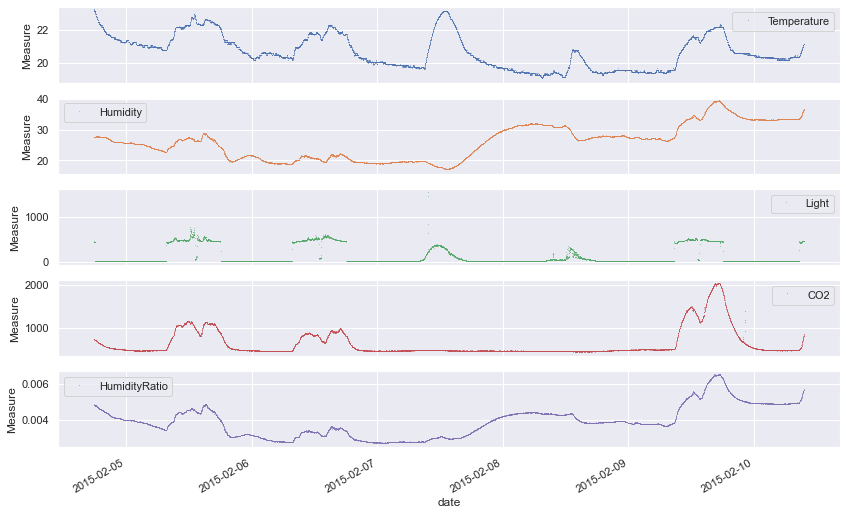

In [30]:
plot_params_against_time(datatraining)

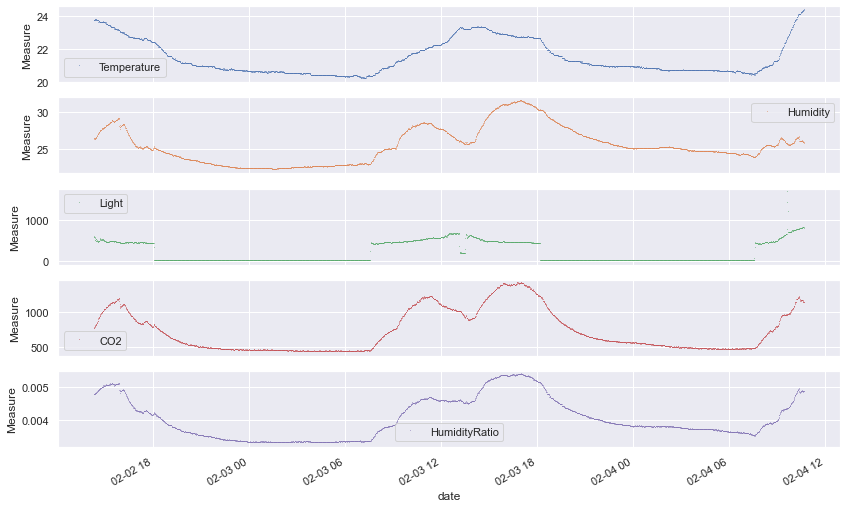

In [31]:
plot_params_against_time(dataset)

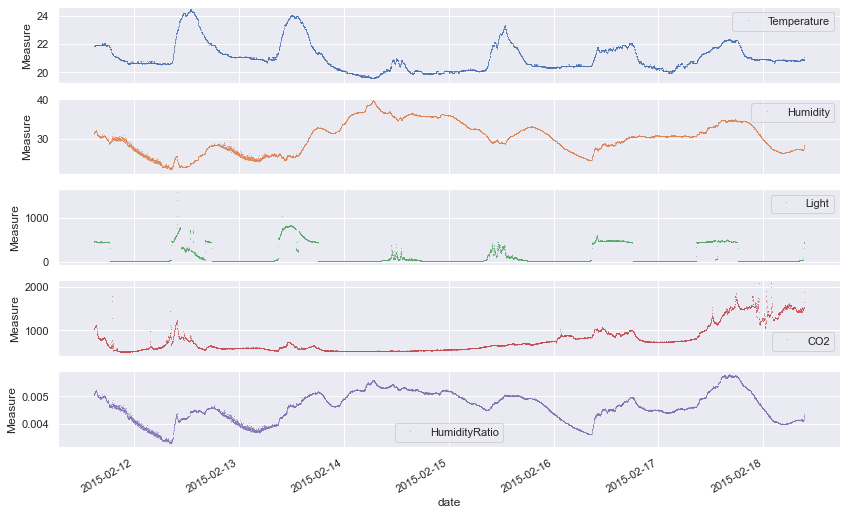

In [32]:
plot_params_against_time(dataset2)

Since we have low values like humidity_ratio and high values like light and CO2, we should normalize the data to simplfy the learning process.

In [17]:
def normalize_values(dataset):
    scaler = MinMaxScaler()
    columns = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']
    dataset[columns] = scaler.fit_transform(np.array(dataset[columns]))
    return dataset

In [18]:
dataset = normalize_values(dataset)
dataset2 = normalize_values(dataset2)
datatraining = normalize_values(datatraining)

In [19]:
datatraining.drop(["date", "Occupancy"], axis = 1).describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature,8143.0,0.387341,0.243281,0.0,0.167464,0.332536,0.571770,1.0
Humidity,8143.0,0.401676,0.247233,0.0,0.154431,0.423623,0.616307,1.0
Light,8143.0,0.077292,0.125947,0.0,0.000000,0.000000,0.165795,1.0
CO2,8143.0,0.119942,0.194536,0.0,0.016246,0.025220,0.139925,1.0
HumidityRatio,8143.0,0.312576,0.224186,0.0,0.106304,0.296338,0.441308,1.0


In [20]:
def box_plots(dataframe):
    plt.figure(figsize = (10, 10))
    plt.title(f"Boxplot for features", fontdict = {"fontsize": 18})
    ax = sns.boxplot(data = dataframe.drop(["date", "Occupancy"], axis = 1), palette = "Set2", orient = "h")
    plt.show()

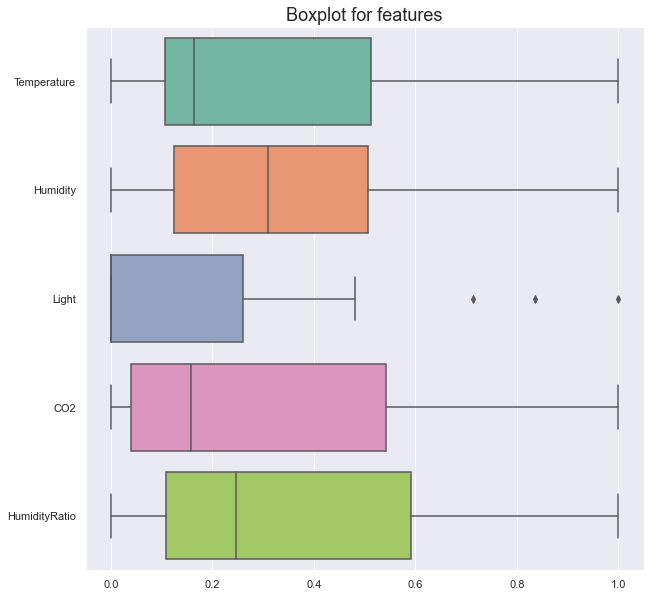

In [21]:
box_plots(dataset)

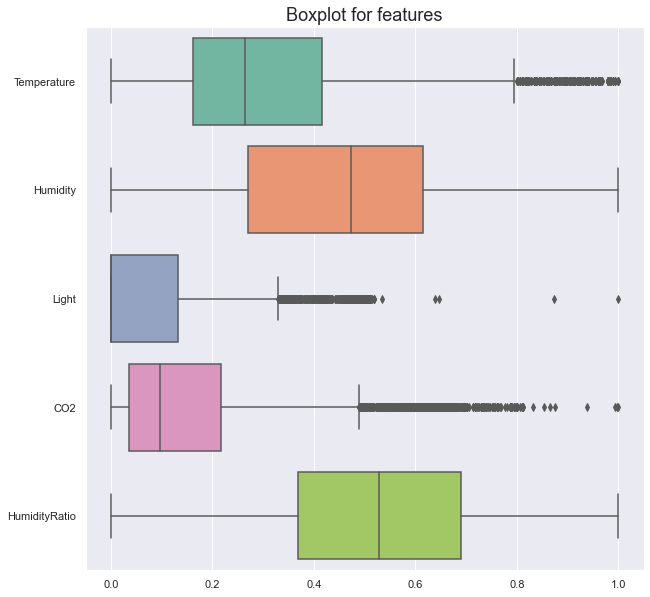

In [22]:
box_plots(dataset2)

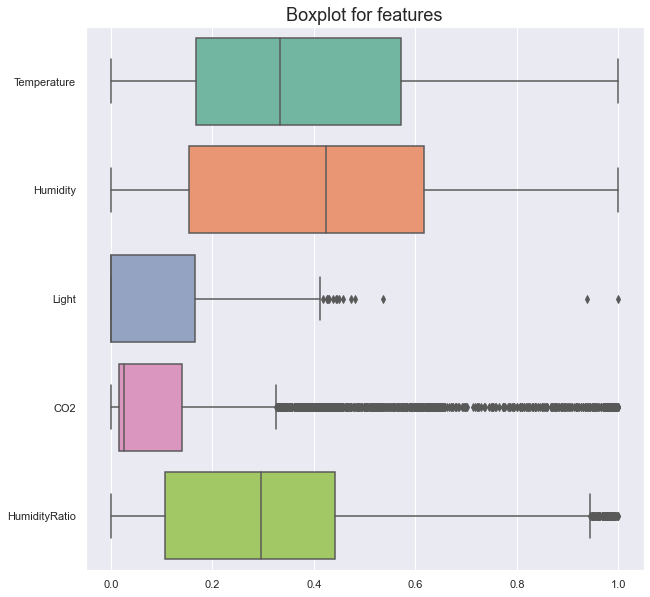

In [23]:
box_plots(datatraining)

In [24]:
def show_correlation_matrix(dataframe):
    plt.figure(figsize=(10, 8))
    plt.title("Correlation table for features", fontdict={"fontsize": 18})
    ax = sns.heatmap(dataframe.corr(), annot=True, linewidths=0.2)
    plt.show()


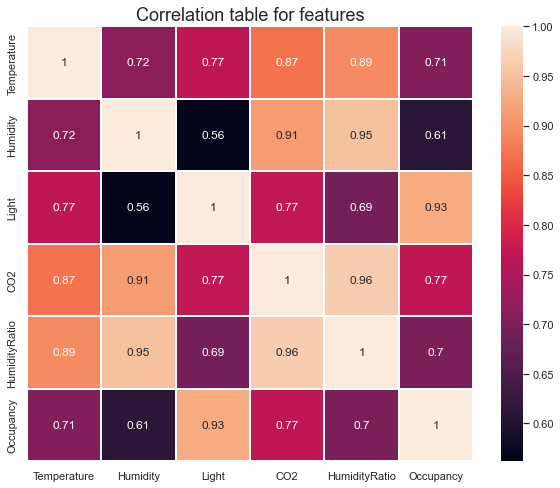

In [25]:
show_correlation_matrix(dataset)

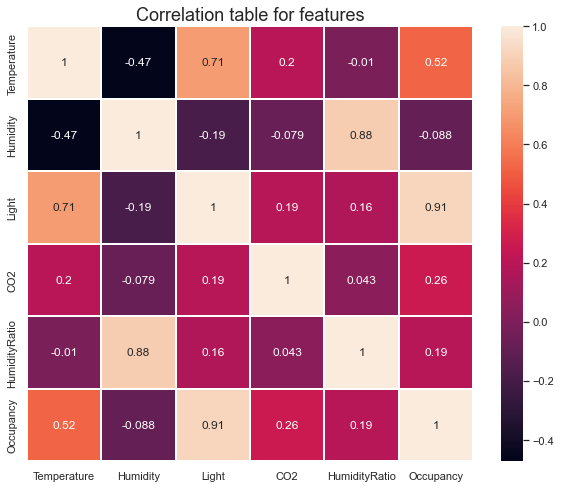

In [26]:
show_correlation_matrix(dataset2)

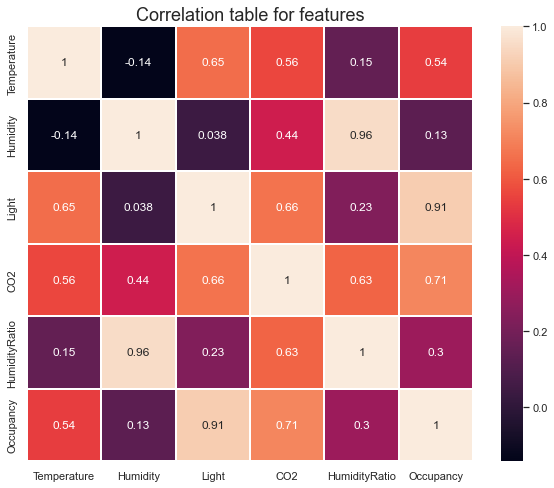

In [28]:
show_correlation_matrix(datatraining)

We can see the correlations between occupancy and the others. As I expected, light value is more correlated with occupancy than others.

In [29]:
def plot_counts(dataframe):
    sns.set(style="darkgrid")
    plt.title("Occupancy Distribution", fontdict={'fontsize':18})
    ax = sns.countplot(x="Occupancy", data=dataframe)
    plt.show()

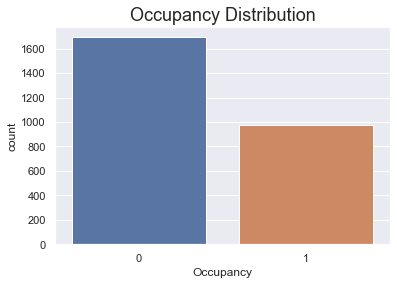

In [30]:
plot_counts(dataset)

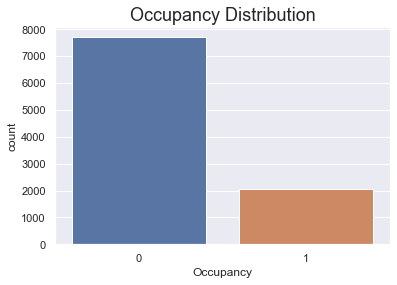

In [31]:
plot_counts(dataset2)

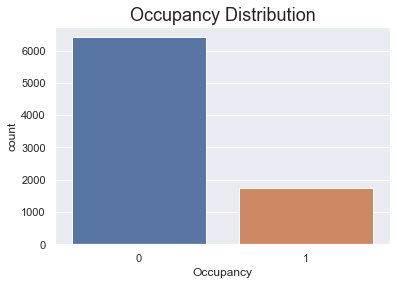

In [32]:
plot_counts(datatraining)

Our data is unbalanced, so we need to find another relations between features to strengthen our predictions. I have a question at this point, is there any relation between occupancy and the hour of the day? Let's look into it.

In [33]:
hours_1 = []
hours_0 = []
for date in datatraining[datatraining['Occupancy'] == 1]['date']:
    hours_1.append(date.hour)
for date in datatraining[datatraining['Occupancy'] == 0]['date']:
    hours_0.append(date.hour)

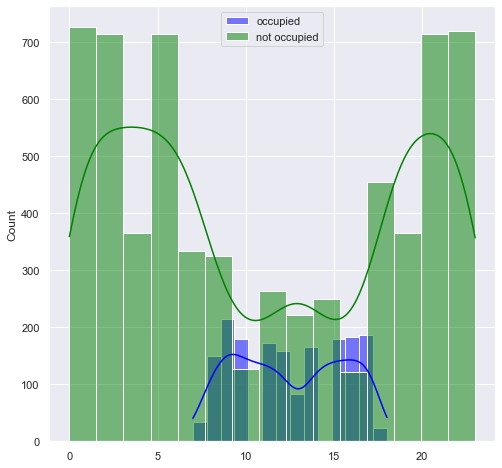

In [43]:
plt.figure(figsize=(8, 8))
ax = sns.histplot(hours_1, color="blue", label = "occupied", kde = True)
ax = sns.histplot(hours_0, color="green", label = "not occupied", kde=True)
plt.legend()
plt.show()



From above histogram, what can you say? Between 07:00 and 18:00 there are occupants in the environment or not. But the time come to non-working hours, then we can absolutely say that there is no occupant. With this information, I will create a new feature from date column as day period.

    07:00 - 18:00 working hour (labeled as 1)
    rest of the day non-working hour (labeled as 0)

In [45]:
def make_period_of_day(dataframe):
    dataframe["period_of_day"] = [1 if (i.hour >= 7 and i.hour <= 17) else 0 for i in dataframe["date"]]
    return dataframe   

In [47]:
dataset = make_period_of_day(dataset)
dataset2 = make_period_of_day(dataset2)
datatraining = make_period_of_day(datatraining)

In [48]:
datatraining.sample(10)

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,period_of_day
7367,2015-02-09 20:38:00,0.370813,0.789138,0.000000,0.263809,0.651672,0,0
4018,2015-02-07 12:49:00,0.980861,0.015868,0.189804,0.022900,0.081016,0,1
7615,2015-02-10 00:46:00,0.308612,0.726562,0.000000,0.040384,0.575232,0,0
3415,2015-02-07 02:45:59,0.212919,0.100793,0.000000,0.017794,0.012340,0,0
7194,2015-02-09 17:44:59,0.741627,0.963013,0.280017,0.921553,0.958363,1,1
7411,2015-02-09 21:22:00,0.358852,0.761873,0.000000,0.174687,0.623317,0,0
2206,2015-02-06 06:36:59,0.308612,0.087384,0.000000,0.012533,0.018726,0,0
7710,2015-02-10 02:21:00,0.308612,0.722092,0.000000,0.031100,0.571327,0,0
4884,2015-02-08 03:15:00,0.093301,0.646106,0.000000,0.015009,0.438916,0,0
7943,2015-02-10 06:14:00,0.263158,0.730584,0.000000,0.021198,0.563651,0,0


### 3. Classification with Machine Learning algorithms

In [49]:
def separate_attributes_and_labels(dataframe):
    X = dataframe.drop(columns = ["date", "Occupancy"], axis = 1)
    y = dataframe["Occupancy"]
    return X, y

In [51]:
X_train, y_train = separate_attributes_and_labels(datatraining)
X_val, y_val = separate_attributes_and_labels(dataset)
X_test, y_test = separate_attributes_and_labels(dataset2)

In [52]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((8143, 6), (8143,), (2665, 6), (2665,), (9752, 6), (9752,))

#### 3.1. KNN (K-nearest neighbors).
Let's try different hyperparameters on KNN model such as n_neighbors, weights and metrics to find best options.

In [53]:
# hyper-parameter tuning for KNN
n_neighbors_list = [7, 15, 45, 135]
weights_list = ["uniform", "distance"]
metric_list = ["euclidean", "manhattan"]
accuracies = {}

In [56]:
for n in n_neighbors_list:
    for weight in weights_list:
        for metric in metric_list:
            knn_model = KNeighborsClassifier(n_neighbors = n, weights = weight, metric = metric)
            knn_model.fit(X_train, y_train)
            accuracy = knn_model.score(X_val, y_val)
            accuracies[str(n) + "/" + weight + "/" + metric] = accuracy

In [57]:
accuracies

{'7/uniform/euclidean': 0.9587242026266416,
 '7/uniform/manhattan': 0.9696060037523452,
 '7/distance/euclidean': 0.9587242026266416,
 '7/distance/manhattan': 0.9696060037523452,
 '15/uniform/euclidean': 0.9538461538461539,
 '15/uniform/manhattan': 0.9643527204502814,
 '15/distance/euclidean': 0.9538461538461539,
 '15/distance/manhattan': 0.9643527204502814,
 '45/uniform/euclidean': 0.9478424015009381,
 '45/uniform/manhattan': 0.9621013133208255,
 '45/distance/euclidean': 0.94859287054409,
 '45/distance/manhattan': 0.9621013133208255,
 '135/uniform/euclidean': 0.9283302063789869,
 '135/uniform/manhattan': 0.9553470919324578,
 '135/distance/euclidean': 0.9283302063789869,
 '135/distance/manhattan': 0.9557223264540338}

In [58]:
plotdata = pd.DataFrame()
plotdata["Parameters"] = accuracies.keys()
plotdata["Accuracy"] = accuracies.values()

In [60]:
fig = px.line(plotdata, x = "Parameters", y = "Accuracy")
fig.update_layout(title = {"text": "Accuracies for Different Hyper-parameters",
                    "x": 0.5, "xanchor": "center", "yanchor": "top"})
iplot(fig)


By looking over the accuracies graph:

    7 is enough for k-value.
    Manhattan distance performs better when k has low value. 
    Uniform weights are better.



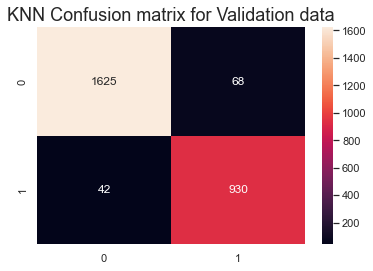

In [61]:
knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_val)
plt.title("KNN Confusion matrix for Validation data", fontdict={"fontsize": 18})
ax = sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt="d")

### 3.2 Support Vector Machine

In [62]:
svm_model = SVC()
svm_model.fit(X_train, y_train)
print("Accuracy for SVM on validation data: {}%".format(round((svm_model.score(X_val, y_val) * 100), 2)))

Accuracy for SVM on validation data: 97.86%


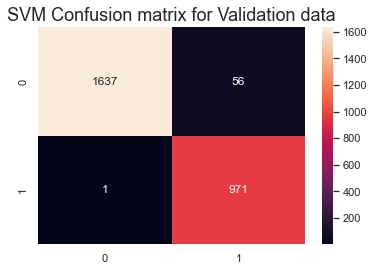

In [63]:
y_pred = svm_model.predict(X_val)
plt.title("SVM Confusion matrix for Validation data", fontdict={"fontsize": 18})
ax = sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt="d")

### 4. Classification with Neural Networks

Firsty, I would like to try different models like with or without regularization methods. I will create four different models:

    Without regularization
    With 0.2 dropout regularization
    With L1(Lasso) regularization
    With L2(Ridge) regularization

After all models trained and evaluated with validation data, we will compare the training and validation losses.

In [64]:
# NN without regularization
model1 = Sequential([
    Dense(32, activation="relu", input_dim = 6),
    Dense(16, activation="relu"),
    Dense(1, activation="sigmoid")
])

In [65]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                224       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


In [66]:
model1.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

In [67]:
history1 = model1.fit(X_train, y_train, epochs=50, batch_size=32,
                        validation_data = (X_val, y_val))

Train on 8143 samples, validate on 2665 samples
Epoch 1/50
8143/8143 [==============================] - 1s 123us/sample - loss: 0.4065 - accuracy: 0.9230 - val_loss: 0.1886 - val_accuracy: 0.9411
Epoch 2/50
8143/8143 [==============================] - 0s 44us/sample - loss: 0.1060 - accuracy: 0.9716 - val_loss: 0.1246 - val_accuracy: 0.9527
Epoch 3/50
8143/8143 [==============================] - 0s 42us/sample - loss: 0.0713 - accuracy: 0.9794 - val_loss: 0.1164 - val_accuracy: 0.9640
Epoch 4/50
8143/8143 [==============================] - 0s 40us/sample - loss: 0.0620 - accuracy: 0.9834 - val_loss: 0.1152 - val_accuracy: 0.9685
Epoch 5/50
8143/8143 [==============================] - 0s 43us/sample - loss: 0.0577 - accuracy: 0.9844 - val_loss: 0.1209 - val_accuracy: 0.9696
Epoch 6/50
8143/8143 [==============================] - 0s 40us/sample - loss: 0.0553 - accuracy: 0.9846 - val_loss: 0.1196 - val_accuracy: 0.9700
Epoch 7/50
8143/8143 [==============================] - 0s 44us/sampl

In [68]:
# NN with 0.2 dropout ratio before the hidden layer
model2 = Sequential([
    Dense(32, activation="relu", input_dim = 6),
    Dropout(0.2),
    Dense(16, activation="relu"),
    Dense(1, activation="sigmoid")
])

In [69]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                224       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


In [70]:
model2.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

In [71]:
history2 = model2.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Train on 8143 samples, validate on 2665 samples
Epoch 1/50
8143/8143 [==============================] - 1s 110us/sample - loss: 0.3074 - accuracy: 0.9041 - val_loss: 0.1408 - val_accuracy: 0.9407
Epoch 2/50
8143/8143 [==============================] - 0s 44us/sample - loss: 0.1055 - accuracy: 0.9704 - val_loss: 0.1165 - val_accuracy: 0.9553
Epoch 3/50
8143/8143 [==============================] - 0s 43us/sample - loss: 0.0791 - accuracy: 0.9790 - val_loss: 0.1140 - val_accuracy: 0.9685
Epoch 4/50
8143/8143 [==============================] - 0s 43us/sample - loss: 0.0657 - accuracy: 0.9822 - val_loss: 0.1095 - val_accuracy: 0.9692
Epoch 5/50
8143/8143 [==============================] - 0s 44us/sample - loss: 0.0609 - accuracy: 0.9832 - val_loss: 0.1077 - val_accuracy: 0.9700
Epoch 6/50
8143/8143 [==============================] - 0s 44us/sample - loss: 0.0571 - accuracy: 0.9844 - val_loss: 0.0965 - val_accuracy: 0.9700
Epoch 7/50
8143/8143 [==============================] - 0s 43us/sampl

In [72]:
# NN with L1(Lasso) regularization
model3 = Sequential([
    Dense(32, activation="relu", input_dim = 6, kernel_regularizer=l1(l=0.01)),
    Dense(16, activation="relu", kernel_regularizer=l1(l=0.01)),
    Dense(1, activation="sigmoid")
])

In [73]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                224       
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


In [74]:
model3.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

In [75]:
history3 = model3.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Train on 8143 samples, validate on 2665 samples
Epoch 1/50
8143/8143 [==============================] - 1s 138us/sample - loss: 1.1518 - accuracy: 0.7931 - val_loss: 0.6602 - val_accuracy: 0.8582
Epoch 2/50
8143/8143 [==============================] - 0s 43us/sample - loss: 0.4499 - accuracy: 0.9131 - val_loss: 0.3631 - val_accuracy: 0.9313
Epoch 3/50
8143/8143 [==============================] - 0s 44us/sample - loss: 0.3267 - accuracy: 0.9580 - val_loss: 0.3001 - val_accuracy: 0.9448
Epoch 4/50
8143/8143 [==============================] - 0s 44us/sample - loss: 0.2825 - accuracy: 0.9640 - val_loss: 0.2751 - val_accuracy: 0.9531
Epoch 5/50
8143/8143 [==============================] - 0s 43us/sample - loss: 0.2572 - accuracy: 0.9665 - val_loss: 0.2625 - val_accuracy: 0.9448
Epoch 6/50
8143/8143 [==============================] - 0s 41us/sample - loss: 0.2379 - accuracy: 0.9713 - val_loss: 0.2439 - val_accuracy: 0.9546
Epoch 7/50
8143/8143 [==============================] - 0s 47us/sampl

In [76]:
# NN with L2(Rigde) Regularization
model4 = Sequential([
    Dense(32, activation="relu", input_dim = 6, kernel_regularizer=l2(l = 0.01)),
    Dense(16, activation="relu", kernel_regularizer=l1(l = 0.01)),
    Dense(1, activation="sigmoid")
])

In [77]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                224       
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


In [78]:
model4.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

In [79]:
history4 = model4.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Train on 8143 samples, validate on 2665 samples
Epoch 1/50
8143/8143 [==============================] - 1s 110us/sample - loss: 0.9868 - accuracy: 0.8276 - val_loss: 0.5268 - val_accuracy: 0.9351
Epoch 2/50
8143/8143 [==============================] - 0s 44us/sample - loss: 0.3920 - accuracy: 0.9655 - val_loss: 0.3394 - val_accuracy: 0.9445
Epoch 3/50
8143/8143 [==============================] - 0s 45us/sample - loss: 0.3075 - accuracy: 0.9678 - val_loss: 0.2898 - val_accuracy: 0.9497
Epoch 4/50
8143/8143 [==============================] - 0s 45us/sample - loss: 0.2706 - accuracy: 0.9689 - val_loss: 0.2628 - val_accuracy: 0.9493
Epoch 5/50
8143/8143 [==============================] - 0s 50us/sample - loss: 0.2453 - accuracy: 0.9715 - val_loss: 0.2446 - val_accuracy: 0.9486
Epoch 6/50
8143/8143 [==============================] - 0s 53us/sample - loss: 0.2263 - accuracy: 0.9729 - val_loss: 0.2304 - val_accuracy: 0.9490
Epoch 7/50
8143/8143 [==============================] - 0s 51us/sampl

In [80]:
loss1 = history1.history["loss"]
val_loss1 = history1.history["val_loss"]
loss2 = history2.history["loss"]
val_loss2 = history2.history["val_loss"]
loss3 = history3.history["loss"]
val_loss3 = history3.history["val_loss"]
loss4 = history4.history["loss"]
val_loss4 = history4.history["val_loss"]

In [81]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = np.arange(len(loss1)), y = loss1, name = "Training loss without Regularization", line=dict(color = "royalblue")))
fig.add_trace(go.Scatter(x = np.arange(len(val_loss1)), y = val_loss1, name = "Validation loss without Regularization", line=dict(color = "firebrick")))

fig.add_trace(go.Scatter(x = np.arange(len(loss2)), y = loss2, name = "Training loss with Dropout", line=dict(color = "royalblue", dash = "dash")))
fig.add_trace(go.Scatter(x = np.arange(len(val_loss2)), y = val_loss2, name = "Validation loss with Dropout", line=dict(color = "firebrick", dash = "dash")))

fig.add_trace(go.Scatter(x = np.arange(len(loss3)), y = loss3, name = "Training loss with L1 Regularization", line=dict(color = "royalblue", dash = "dot")))
fig.add_trace(go.Scatter(x = np.arange(len(val_loss3)), y = val_loss3, name = "Validation loss with L1 Regularization", line=dict(color = "firebrick", dash = "longdashdot")))

fig.add_trace(go.Scatter(x = np.arange(len(loss4)), y = loss4, name = "Training loss with L2 Regularization", line=dict(color = "royalblue", dash = "dot")))
fig.add_trace(go.Scatter(x = np.arange(len(val_loss4)), y = val_loss4, name = "Validation loss with L2 Regularization", line=dict(color = "firebrick", dash = "longdashdot")))

fig.update_layout(xaxis_title = "Epochs", yaxis_title = "Loss",
                    title = {"text": "Training and validation Losses for Different Neural Networks",
                            "x": 0.5, "xanchor": "center", "yanchor": "top"})
iplot(fig)

    ! NN without regularization is unstabilized as expected.
    ! Dropout and L2 regularization doing well.
    ! L1 regularization is stable but it has biggest loss value.

So our best option will be a dropout layer and L2 regularization on layers. Let's train it.

P.S. You can click on the legend to close some of lines. It might be useful when examining the plot.


In [82]:
model = Sequential([
    Dense(32, activation="relu", input_dim = 6, kernel_regularizer=l2(l = 0.01)),
    Dropout(0.3),
    Dense(32, activation="relu", kernel_regularizer=l2(l=0.01)),
    Dense(1, activation="sigmoid")
])

In [83]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                224       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 1,313
Trainable params: 1,313
Non-trainable params: 0
_________________________________________________________________


In [84]:
model.compile(optimizer="rmsprop", loss = "binary_crossentropy", metrics=["accuracy"])

In [85]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Train on 8143 samples, validate on 2665 samples
Epoch 1/50
8143/8143 [==============================] - 1s 112us/sample - loss: 0.5970 - accuracy: 0.8373 - val_loss: 0.3186 - val_accuracy: 0.9362
Epoch 2/50
8143/8143 [==============================] - 0s 40us/sample - loss: 0.2658 - accuracy: 0.9425 - val_loss: 0.2212 - val_accuracy: 0.9550
Epoch 3/50
8143/8143 [==============================] - 0s 47us/sample - loss: 0.2070 - accuracy: 0.9587 - val_loss: 0.1997 - val_accuracy: 0.9550
Epoch 4/50
8143/8143 [==============================] - 0s 44us/sample - loss: 0.1833 - accuracy: 0.9661 - val_loss: 0.1869 - val_accuracy: 0.9591
Epoch 5/50
8143/8143 [==============================] - 0s 43us/sample - loss: 0.1665 - accuracy: 0.9718 - val_loss: 0.1734 - val_accuracy: 0.9629
Epoch 6/50
8143/8143 [==============================] - 0s 44us/sample - loss: 0.1555 - accuracy: 0.9753 - val_loss: 0.1668 - val_accuracy: 0.9685
Epoch 7/50
8143/8143 [==============================] - 0s 46us/sampl

### 5. Comparing Performances of SVM and Neural Network
Let's test our models with the test data. This data has nearly 10000 instances. I will evaluate them with accuracy metric first, after then we will look into confusion matrix.

In [88]:
print(f"Accuracy for SVM on test data: {round((svm_model.score(X_test, y_test) * 100), 2)}%.")
print(f"Accuracy for Neural Network model on test data: {round((model.evaluate(X_test, y_test)[1] * 100), 2)}%.")

Accuracy for SVM on test data: 97.62%.
9752/9752 [==============================] - 0s 17us/sample - loss: 0.0865 - accuracy: 0.9893
Accuracy for Neural Network model on test data: 98.93%.


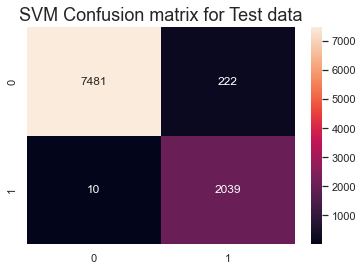

In [89]:
y_pred = svm_model.predict(X_test)
plt.title("SVM Confusion matrix for Test data", fontdict={"fontsize": 18})
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")

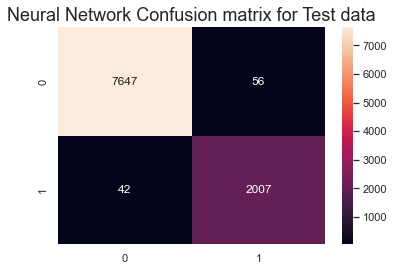

In [90]:
y_pred = model.predict(X_test)
threshold = 0.6
y_pred = [1 if i >= threshold else 0 for i in y_pred]
plt.title("Neural Network Confusion matrix for Test data", fontdict={"fontsize": 18})
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")


### 6. Conclusion

Both of the models did great job when predicting occupancy. Our accuracy is nearly 98%. So what do you think, which method (ML or DL) is suitable for this dataset and problem?

Before answer that, look at the confusion matrix which are created when evaluating models with the test data. SVM model looks like biased toward occupied class. But we don't have that problem with neural network. So we can say that, we could use neural network for more stable and accurate results without significant errors.
